#UTS Model Deployment  
## 2702211512 - Tyrone Yutanesy Iman

#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import warnings
import pickle
import os

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('Dataset_B_hotel.csv')

In [3]:
print("First 5 rows:")
print(df.head())
print("\nShape:", df.shape)
print("\nColumns:", df.columns)
print("\nInfo:")
print(df.info())

First 5 rows:
  Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                         0.0   
1                  3      Not Selected                         0.0   
2                  1       Meal Plan 1                         0.0   
3                  2       Meal Plan 1                         0.0   
4                  1      Not Selected                         0.0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   


# Prepocessing

Check NULL Values and Duplicate Data

In [4]:
print("\nMissing values before:")
print(df.isnull().sum())
df.dropna(inplace=True)
print("\nMissing values after:")
print(df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)


Missing values before:
Booking_ID                                 0
no_of_adults                               0
no_of_children                             0
no_of_weekend_nights                       0
no_of_week_nights                          0
type_of_meal_plan                        907
required_car_parking_space              1270
room_type_reserved                         0
lead_time                                  0
arrival_year                               0
arrival_month                              0
arrival_date                               0
market_segment_type                        0
repeated_guest                             0
no_of_previous_cancellations               0
no_of_previous_bookings_not_canceled       0
avg_price_per_room                      1632
no_of_special_requests                     0
booking_status                             0
dtype: int64

Missing values after:
Booking_ID                              0
no_of_adults                            0
n

# EDA

In [5]:
categorical_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
binary_map = {'No': 0, 'Yes': 1}

label_encoders = {}
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

if 'repeated_guest' in df.columns:
    df['repeated_guest'] = df['repeated_guest'].map(binary_map)

In [6]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\nShapiro-Wilk Normality Test:")
for col in numerical_cols:
    stat, p = shapiro(df[col])
    print(f"{col}: W={stat:.4f}, p-value={p:.4f}")



Shapiro-Wilk Normality Test:
no_of_adults: W=0.6909, p-value=0.0000
no_of_children: W=0.2777, p-value=0.0000
no_of_weekend_nights: W=0.7782, p-value=0.0000
no_of_week_nights: W=0.8684, p-value=0.0000
type_of_meal_plan: W=0.5171, p-value=0.0000
required_car_parking_space: W=0.1613, p-value=0.0000
room_type_reserved: W=0.5442, p-value=0.0000
lead_time: W=0.8578, p-value=0.0000
arrival_year: W=0.4658, p-value=0.0000
arrival_month: W=0.9471, p-value=0.0000
arrival_date: W=0.9564, p-value=0.0000
market_segment_type: W=0.6628, p-value=0.0000
repeated_guest: W=nan, p-value=nan
no_of_previous_cancellations: W=0.0356, p-value=0.0000
no_of_previous_bookings_not_canceled: W=0.0612, p-value=0.0000
avg_price_per_room: W=0.9510, p-value=0.0000
no_of_special_requests: W=0.7445, p-value=0.0000


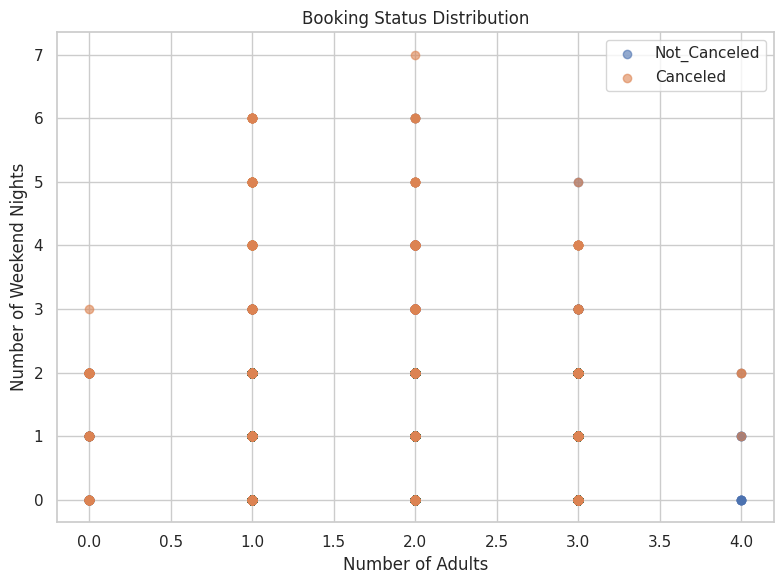

In [7]:
plt.figure(figsize=(8, 6))
for status in df['booking_status'].unique():
    subset = df[df['booking_status'] == status]
    plt.scatter(subset['no_of_adults'], subset['no_of_weekend_nights'], label=status, alpha=0.6)
plt.xlabel('Number of Adults')
plt.ylabel('Number of Weekend Nights')
plt.title('Booking Status Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Encode

In [8]:
X = df.drop(columns=['booking_status', 'Booking_ID'], errors='ignore')
y = df['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
# Before fitting the xgb model
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
le = LabelEncoder()

# Fit and transform the target variable
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Scaling

In [9]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Model

#Random Forest

In [13]:
rf = RandomForestClassifier(max_depth=4, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

#XGBoost

In [14]:
xgb = XGBClassifier(max_depth=4, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [15]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf.predict(X_test_scaled)))

print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb.predict(X_test_scaled)))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.44      0.59      2146
           1       0.78      0.97      0.86      4376

    accuracy                           0.80      6522
   macro avg       0.83      0.71      0.73      6522
weighted avg       0.81      0.80      0.77      6522


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      2146
           1       0.90      0.93      0.91      4376

    accuracy                           0.88      6522
   macro avg       0.87      0.86      0.87      6522
weighted avg       0.88      0.88      0.88      6522



# Tuning Model

In [16]:
param_grid = {
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
                           param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train_scaled, y_train)

best_xgb = grid_search.best_estimator_
print("\nBest XGBoost Parameters:", grid_search.best_params_)
print("\nTuned XGBoost Classification Report:")
print(classification_report(y_test, best_xgb.predict(X_test_scaled)))


Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      2146
           1       0.91      0.93      0.92      4376

    accuracy                           0.89      6522
   macro avg       0.88      0.87      0.88      6522
weighted avg       0.89      0.89      0.89      6522



In [18]:
os.makedirs("models", exist_ok=True)
with open("best_xgboost_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)
print("\nBest XGBoost model saved to 'best_xgboost_model.pkl'")


Best XGBoost model saved to 'best_xgboost_model.pkl'


First 5 rows:
   Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                         0.0   
1                  3      Not Selected                         0.0   
2                  1       Meal Plan 1                         0.0   
3                  2       Meal Plan 1                         0.0   
4                  1      Not Selected                         0.0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   

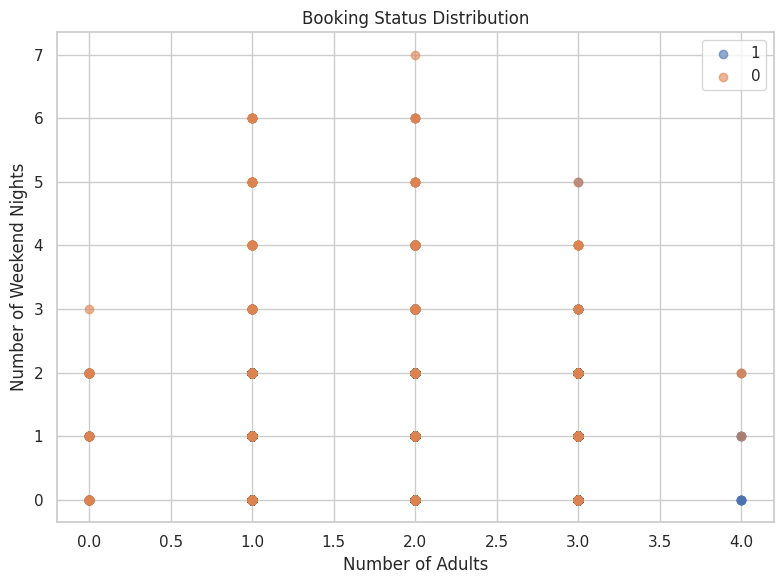


Training Random Forest and XGBoost...

Random Forest Report:
              precision    recall  f1-score   support

           0       0.88      0.44      0.59      2146
           1       0.78      0.97      0.86      4376

    accuracy                           0.80      6522
   macro avg       0.83      0.71      0.73      6522
weighted avg       0.81      0.80      0.77      6522


XGBoost Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      2146
           1       0.90      0.93      0.91      4376

    accuracy                           0.88      6522
   macro avg       0.87      0.86      0.87      6522
weighted avg       0.88      0.88      0.88      6522


Tuning XGBoost with GridSearchCV...

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      2146
           1       

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import warnings
import pickle
import os

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

class BookingModel:
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)
        self.label_encoders = {}
        self.scaler = RobustScaler()
        self.model = None

    def inspect_data(self):
        print("First 5 rows:\n", self.df.head())
        print("\nShape:", self.df.shape)
        print("\nColumns:", self.df.columns)
        print("\nInfo:")
        print(self.df.info())

    def clean_data(self):
        self.df.dropna(inplace=True)
        self.df.drop_duplicates(inplace=True)

    def encode_features(self):
        categorical_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
        binary_map = {'No': 0, 'Yes': 1}

        for col in categorical_cols:
            if col in self.df.columns:
                le = LabelEncoder()
                self.df[col] = le.fit_transform(self.df[col])
                self.label_encoders[col] = le

        if 'repeated_guest' in self.df.columns:
            self.df['repeated_guest'] = self.df['repeated_guest'].map(binary_map)

        if 'booking_status' in self.df.columns:
            le = LabelEncoder()
            self.df['booking_status'] = le.fit_transform(self.df['booking_status'])
            self.label_encoders['booking_status'] = le

    def test_normality(self):
        print("\nShapiro-Wilk Normality Test:")
        numerical_cols = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        for col in numerical_cols:
            stat, p = shapiro(self.df[col])
            print(f"{col}: W={stat:.4f}, p-value={p:.4f}")

    def visualize(self):
        plt.figure(figsize=(8, 6))
        for status in self.df['booking_status'].unique():
            subset = self.df[self.df['booking_status'] == status]
            plt.scatter(subset['no_of_adults'], subset['no_of_weekend_nights'], label=status, alpha=0.6)
        plt.xlabel('Number of Adults')
        plt.ylabel('Number of Weekend Nights')
        plt.title('Booking Status Distribution')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def prepare_data(self):
        X = self.df.drop(columns=['booking_status', 'Booking_ID'], errors='ignore')
        y = self.df['booking_status']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

    def train_models(self):
        print("\nTraining Random Forest and XGBoost...")
        rf = RandomForestClassifier(max_depth=4, random_state=42)
        xgb = XGBClassifier(max_depth=4, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

        rf.fit(self.X_train_scaled, self.y_train)
        self.y_train = self.y_train.astype(int)  # Ensure labels are int for XGBoost
        xgb.fit(self.X_train_scaled, self.y_train)

        print("\nRandom Forest Report:")
        print(classification_report(self.y_test, rf.predict(self.X_test_scaled)))

        print("\nXGBoost Report:")
        print(classification_report(self.y_test, xgb.predict(self.X_test_scaled)))

        self.model = xgb

    def tune_model(self):
        print("\nTuning XGBoost with GridSearchCV...")
        param_grid = {
            'max_depth': [2, 4, 6],
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1]
        }
        grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
                                   param_grid, scoring='f1_macro', cv=5)
        grid_search.fit(self.X_train_scaled, self.y_train)
        self.model = grid_search.best_estimator_

        print("\nBest Parameters:", grid_search.best_params_)
        print("\nClassification Report:")
        print(classification_report(self.y_test, self.model.predict(self.X_test_scaled)))

    def save_model(self, filename="best_xgboost_model.pkl"):
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, 'wb') as f:
            pickle.dump(self.model, f)
        print(f"Model saved to {filename}")


if __name__ == '__main__':
    bm = BookingModel('Dataset_B_hotel.csv')
    bm.inspect_data()
    bm.clean_data()
    bm.encode_features()
    bm.test_normality()
    bm.visualize()
    bm.prepare_data()
    bm.train_models()
    bm.tune_model()
    bm.save_model()
